In [1]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from entot.models.model import OTFlowMatchingGeo
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal,MLP_fused_vector_field
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but al

In [2]:
adata = sc.read("../../data/adata_pancreas_2019_endocrine.h5ad")
sc.pp.pca(adata, n_comps=30)
#sc.pp.neighbors(adata)
#sc.tl.umap(adata)
#sc.pl.umap(adata, color="celltype")

In [3]:
(adata.obs["day"].values == np.sort(adata.obs["day"].values)).all()

True

In [4]:
source_train = adata[adata.obs["day"]=="14.5"].obsm["X_pca"]
target_train = adata[adata.obs["day"]=="15.5"].obsm["X_pca"]


In [5]:
ot_solver=ott.solvers.linear.sinkhorn.Sinkhorn()
neural_net = MLP_vector_field(target_train.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(target_train.shape[1], 1)


otfm = OTFlowMatchingGeo(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, cost_fn="graph", graph_kwargs={"k_neighbors": 64}, epsilon=1e-2, scale_cost="mean", input_dim=30, output_dim=30, iterations=5_000, k_noise_per_x=1)

In [6]:
otfm.iterations=30_000
otfm(source_train, target_train, 1024, 1024)

100%|██████████| 30000/30000 [3:05:45<00:00,  2.69it/s]  


In [7]:
def compute_densities(source: jnp.ndarray, compute_densities_at: jnp.ndarray, rng: jax.Array, approx=True):

    def normal_log_likelihood(y):
        return -0.5 * (y.size * math.log(2 * math.pi) + jnp.sum(y**2))

    def compute_p(target: jnp.ndarray, eps: jnp.ndarray):
        def approx_logp_wrapper(t, y, args):
            y, _ = y
            *args, eps, func = args
            fn = lambda x: func(t=t, latent=x)
            f, vjp_fn = jax.vjp(fn, y)
            (eps_dfdy,) = vjp_fn(eps)
            logp = jnp.sum(eps_dfdy * eps)
            return f, logp

        def exact_logp_wrapper(t, y, args):
            y, _ = y
            y = jnp.atleast_2d(y)[0,:]
            *args, _, func = args
            fn = lambda x: func(t=t, latent=x)
            f, vjp_fn = jax.vjp(fn, y)
            eye = jnp.eye(y.shape[-1])[:,None]
            (dfdy,) = jax.vmap(vjp_fn)(eye)
            logp = jnp.trace(dfdy)
            return f, logp
        
        fn_partial = partial(
                otfm.state_neural_net.apply_fn, {"params": otfm.state_neural_net.params}, condition=source,
            )
        
        term = diffrax.ODETerm(approx_logp_wrapper) if approx else diffrax.ODETerm(exact_logp_wrapper)
        t0=0.0
        t1=1.0
        dt0=0.00001
        eps = jnp.atleast_2d(eps)
        target = jnp.atleast_2d(target)
        x1_f1_stacked = (target, 0.0)
        solver = diffrax.Tsit5()
        saveat = diffrax.SaveAt(ts=jnp.linspace(1, 0, 11))
        
        sol = diffrax.diffeqsolve(
            term, solver, t1, t0, -dt0, x1_f1_stacked, (eps, fn_partial), saveat=saveat, stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6)#, saveat=saveat
        )
        return sol.ys

    eps = jax.random.normal(rng, (1,))
    eps = jnp.ones_like(compute_densities_at) * eps
    compute_p_vmapped = jax.vmap(compute_p)
    out = compute_p_vmapped(compute_densities_at, eps)
    x_0 = jnp.squeeze(jnp.asarray(out[0]))
    f_0 = jnp.squeeze(jnp.asarray(out[1]))
    target_dim = compute_densities_at.shape[-1]
    logl = jax.scipy.stats.multivariate_normal.logpdf(x_0, np.zeros(target_dim), np.eye(target_dim))
    ps = jnp.exp(logl+f_0)
    return x_0, f_0, ps


In [7]:
from functools import partial
import math
import diffrax
from tqdm import tqdm

In [9]:
out_len = len(source_train)
batch_size = 20

In [10]:
compute_densities_at = target_train
source_selected = source_train

outputs = []
for batch in tqdm(range(0, out_len, batch_size)):
    out = jax.vmap(partial(compute_densities, compute_densities_at=compute_densities_at, rng=jax.random.PRNGKey(0), approx=True))(source_selected[batch:min(out_len, batch+batch_size),:])
    outputs.append(jax.device_put(out, device=jax.devices("cpu")[0]))
    
    

100%|██████████| 221/221 [1:42:22<00:00, 27.79s/it]


In [11]:
r = []
for batch in outputs:
    r.append(batch[-1])

In [12]:
r_arr = np.vstack(r)


In [40]:
np.save("pancreas_densities_geodesic_cost", r_arr)

In [13]:
outs_arr_fin = r_arr[...,-1]

In [14]:
mass_ps = outs_arr_fin.sum(axis=1)

In [15]:
normalized_ps = outs_arr_fin / mass_ps[:,None]

In [8]:
import pandas as pd

tmat=normalized_ps
aggregation_key="celltype"
adata_source = adata[adata.obs["day"]=="14.5"]
adata_target = adata[adata.obs["day"]=="15.5"]
df_source = adata_source.obs[aggregation_key]
df_target = adata_target.obs[aggregation_key]

annotations_source = adata_source.obs[aggregation_key].cat.categories
annotations_target = adata_target.obs[aggregation_key].cat.categories

tm = pd.DataFrame(
    np.zeros((len(annotations_source), len(annotations_target))),
    index=annotations_source,
    columns=annotations_target,
)

for annotation_src in annotations_source:
    for annotation_tgt in annotations_target:
        tm.loc[annotation_src, annotation_tgt] = tmat[
            np.ix_((df_source == annotation_src).squeeze(), (df_target == annotation_tgt).squeeze())
        ].sum()

NameError: name 'normalized_ps' is not defined

In [19]:
forward=True
tm.div(tm.sum(axis=int(forward)), axis=int(not forward))

,Ngn3 low EP,Ngn3 High late,Fev+ Beta,Beta,Fev+ Alpha,Alpha,Fev+ Pyy,Fev+ Delta,Fev+ Epsilon,Delta,Epsilon
Ngn3 low EP,0.270733,0.644841,0.001879,0.068751,4.015264e-09,0.007302,0.000002,0.000002,0.001675,0.000249,0.004567
Ngn3 High early,0.598684,0.193551,0.038012,0.153630,1.203130e-07,0.007126,0.000096,0.000317,0.001021,0.001596,0.005966
Ngn3 High late,0.754588,0.183217,0.023032,0.033686,6.476189e-08,0.001776,0.000013,0.000271,0.001175,0.000093,0.002148
Fev+ Beta,0.233925,0.115258,0.073341,0.529400,1.556505e-07,0.033269,0.000515,0.000526,0.000444,0.003788,0.009535
Beta,0.304796,0.078931,0.088640,0.417975,2.122108e-07,0.083222,0.001055,0.000892,0.000612,0.007955,0.015921
Fev+ Alpha,0.104789,0.082030,0.014934,0.741293,2.273589e-08,0.039359,0.000225,0.000269,0.000377,0.005184,0.011538
Alpha,0.190163,0.039943,0.079049,0.650041,1.466552e-07,0.027397,0.000707,0.000466,0.000244,0.004282,0.007708
Fev+ Pyy,0.087767,0.030930,0.043805,0.796178,5.521537e-08,0.028985,0.000396,0.000256,0.000149,0.003779,0.007755
Fev+ Delta,0.104418,0.078208,0.030213,0.719035,5.644516e-08,0.050047,0.000460,0.000344,0.000373,0.005085,0.011817
Fev+ Epsilon,0.278653,0.133059,0.084647,0.451615,2.407987e-07,0.035307,0.000532,0.000929,0.000584,0.002369,0.012305


In [20]:
forward=False
tm.div(tm.sum(axis=int(forward)), axis=int(not forward))

,Ngn3 low EP,Ngn3 High late,Fev+ Beta,Beta,Fev+ Alpha,Alpha,Fev+ Pyy,Fev+ Delta,Fev+ Epsilon,Delta,Epsilon
Ngn3 low EP,0.143578,0.578497,0.007564,0.038373,0.007361,0.051214,0.000747,0.001100,0.381729,0.016423,0.116383
Ngn3 High early,0.007919,0.004331,0.003815,0.002139,0.005501,0.001247,0.001182,0.003868,0.005805,0.002629,0.003792
Ngn3 High late,0.499513,0.205166,0.115699,0.023468,0.148189,0.015546,0.008149,0.165203,0.334417,0.007705,0.068340
Fev+ Beta,0.129804,0.108189,0.308829,0.309167,0.298551,0.244155,0.266505,0.268694,0.105858,0.261798,0.254255
Beta,0.112497,0.049281,0.248270,0.162360,0.270743,0.406248,0.363510,0.303261,0.097126,0.365740,0.282377
Fev+ Alpha,0.006798,0.009002,0.007352,0.050613,0.005098,0.033770,0.013623,0.016108,0.010526,0.041892,0.035967
Alpha,0.076415,0.027152,0.241052,0.274912,0.203709,0.145607,0.265021,0.172466,0.042069,0.214341,0.148846
Fev+ Pyy,0.004644,0.002768,0.017587,0.044332,0.010098,0.020282,0.019553,0.012489,0.003390,0.024902,0.019715
Fev+ Delta,0.003157,0.004000,0.006932,0.022878,0.005899,0.020011,0.012988,0.009576,0.004845,0.019149,0.017168
Fev+ Epsilon,0.008775,0.007088,0.020229,0.014968,0.026213,0.014706,0.015635,0.026954,0.007906,0.009291,0.018621


In [10]:
from typing import Tuple, Callable, Union, List, Optional
import scipy.sparse as sp
import jax.numpy as jnp
import jax
import pandas as pd

def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  
        predicted_tgt_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 1,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None))
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        for index in range(0, len(predicted_tgt_cells), batch_size):
            _, indices = get_knn_fn(predicted_tgt_cells[index : index + batch_size], tgt_cells, k)
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(predicted_tgt_cells) - index)), min(k, len(tgt_cells)))
            )
        ri = jnp.concatenate(row_indices)
        ci = jnp.concatenate(column_indices)
        mat = np.zeros((len(ri), len(tgt_cells)))
        mat[ri,ci] = 1.0
        return mat

def aggregate_transport_matrix(adata_source, adata_target, tmat, aggregation_key = "celltype", forward = True):
    df_source = adata_source.obs[aggregation_key]
    df_target = adata_target.obs[aggregation_key]

    annotations_source = adata_source.obs[aggregation_key].cat.categories
    annotations_target = adata_target.obs[aggregation_key].cat.categories

    tm = pd.DataFrame(
        np.zeros((len(annotations_source), len(annotations_target))),
        index=annotations_source,
        columns=annotations_target,
    )
    
    for annotation_src in annotations_source:
        for annotation_tgt in annotations_target:
            tm.loc[annotation_src, annotation_tgt] = tmat[
                np.ix_((df_source == annotation_src).squeeze(), (df_target == annotation_tgt).squeeze())
            ].sum()
    return tm.div(tm.sum(axis=int(forward)), axis=int(not forward))

In [7]:
push_train = [None] * 30

for i in range(30):
    push_train[i] = otfm.transport(source_train, seed=i)[0][0,...]
    
gex_predicted_train = jnp.mean(np.asarray(push_train), axis=0)

In [8]:
import pandas as pd

In [11]:
tm = project_transport_matrix(push_train[0], target_train)
adata_source = adata[adata.obs["day"]=="14.5"]
adata_target = adata[adata.obs["day"]=="15.5"]
agg_tm = aggregate_transport_matrix(adata_source, adata_target, tm, forward=False)

In [12]:
agg_tm

,Ngn3 low EP,Ngn3 High late,Fev+ Beta,Beta,Fev+ Alpha,Alpha,Fev+ Pyy,Fev+ Delta,Fev+ Epsilon,Delta,Epsilon
Ngn3 low EP,0.690860,0.149508,0.143363,0.133967,0.0,0.152406,0.061224,0.250000,0.238095,0.146341,0.147170
Ngn3 High early,0.002688,0.005372,0.007080,0.006050,0.0,0.001337,0.000000,0.000000,0.000000,0.012195,0.003774
Ngn3 High late,0.096774,0.394808,0.214159,0.169404,0.4,0.208556,0.224490,0.222222,0.238095,0.146341,0.237736
Fev+ Beta,0.064516,0.188899,0.263717,0.185825,0.2,0.220588,0.285714,0.194444,0.238095,0.304878,0.245283
Beta,0.061828,0.072516,0.111504,0.263613,0.0,0.090909,0.102041,0.055556,0.142857,0.158537,0.086792
Fev+ Alpha,0.013441,0.023277,0.038938,0.019879,0.2,0.021390,0.000000,0.027778,0.000000,0.012195,0.030189
Alpha,0.056452,0.111907,0.146903,0.152118,0.2,0.219251,0.204082,0.138889,0.047619,0.134146,0.154717
Fev+ Pyy,0.005376,0.012534,0.026549,0.020743,0.0,0.021390,0.000000,0.027778,0.000000,0.060976,0.026415
Fev+ Delta,0.002688,0.010743,0.015929,0.012100,0.0,0.010695,0.040816,0.000000,0.000000,0.000000,0.007547
Fev+ Epsilon,0.002688,0.010743,0.008850,0.008643,0.0,0.014706,0.061224,0.055556,0.047619,0.012195,0.015094


In [13]:
agg_tms = []
for i in range(30):
    tm = project_transport_matrix(push_train[i], target_train)
    adata_source = adata[adata.obs["day"]=="14.5"]
    adata_target = adata[adata.obs["day"]=="15.5"]
    agg_tms.append(aggregate_transport_matrix(adata_source, adata_target, tm, forward=False).values)

In [14]:
agg_tms_arr = np.asarray(agg_tms)

In [16]:
agg_tm_mean= pd.DataFrame(data=agg_tms_arr.mean(axis=0), index=agg_tm.index, columns=agg_tm.columns)

In [17]:
agg_tm_mean

,Ngn3 low EP,Ngn3 High late,Fev+ Beta,Beta,Fev+ Alpha,Alpha,Fev+ Pyy,Fev+ Delta,Fev+ Epsilon,Delta,Epsilon
Ngn3 low EP,0.673344,0.141896,0.155883,0.131212,0.198730,0.142970,0.159308,0.150584,0.155871,0.155757,0.165878
Ngn3 High early,0.001357,0.006346,0.004321,0.004727,0.000000,0.004810,0.003358,0.003163,0.007349,0.006032,0.003893
Ngn3 High late,0.109752,0.393011,0.205569,0.176473,0.218082,0.200705,0.214390,0.239069,0.221949,0.220785,0.221369
Fev+ Beta,0.081897,0.184448,0.277188,0.190107,0.266138,0.218904,0.231149,0.225029,0.249397,0.232160,0.235706
Beta,0.035939,0.075388,0.094748,0.269447,0.054167,0.107715,0.112447,0.096438,0.085523,0.118058,0.097326
Fev+ Alpha,0.011079,0.021252,0.029251,0.022630,0.026111,0.026418,0.031419,0.030041,0.028814,0.029441,0.027397
Alpha,0.059782,0.117224,0.152381,0.138182,0.089656,0.222344,0.167151,0.151353,0.164333,0.154003,0.167692
Fev+ Pyy,0.007638,0.016915,0.023194,0.019134,0.041389,0.021960,0.025075,0.026423,0.033105,0.021073,0.023603
Fev+ Delta,0.004202,0.010265,0.012914,0.011100,0.033333,0.012023,0.007324,0.018512,0.015521,0.012471,0.012961
Fev+ Epsilon,0.004871,0.010759,0.015362,0.010247,0.024206,0.012693,0.014228,0.017029,0.009151,0.012049,0.014240


In [35]:
agg_tm.round(2)

,Ngn3 low EP,Ngn3 High late,Fev+ Beta,Beta,Fev+ Alpha,Alpha,Fev+ Pyy,Fev+ Delta,Fev+ Epsilon,Delta,Epsilon
Ngn3 low EP,0.22,0.68,0.02,0.03,0.00,0.03,0.02,0.01,0.14,0.00,0.12
Ngn3 High early,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00
Ngn3 High late,0.62,0.27,0.48,0.02,0.14,0.01,0.03,0.43,0.73,0.02,0.18
Fev+ Beta,0.07,0.03,0.20,0.32,0.57,0.30,0.38,0.23,0.06,0.26,0.28
Beta,0.05,0.01,0.12,0.13,0.14,0.29,0.16,0.16,0.03,0.30,0.21
Fev+ Alpha,0.01,0.00,0.00,0.06,0.00,0.04,0.05,0.00,0.01,0.04,0.01
Alpha,0.02,0.01,0.13,0.29,0.14,0.21,0.26,0.14,0.01,0.32,0.11
Fev+ Pyy,0.00,0.00,0.01,0.05,0.00,0.03,0.02,0.00,0.00,0.03,0.02
Fev+ Delta,0.00,0.00,0.00,0.03,0.00,0.03,0.00,0.00,0.00,0.00,0.00
Fev+ Epsilon,0.01,0.00,0.02,0.01,0.00,0.01,0.08,0.01,0.00,0.02,0.02


In [36]:
agg_tm.to_csv("pancreas_agg_tm_geodesic_cost.csv")

In [14]:
cosine_vars_train = compute_directional_statistics_from_samples(push_train, 2, adata_source.obs_names)

NameError: name 'compute_directional_statistics_from_samples' is not defined

In [ ]:
bdata.obs["directional_variance"] = cosine_vars_test[0]["directional_variance"]
bdata.obs["directional_difference"] = cosine_vars_test[0]["directional_difference"]
bdata.obs["directional_cosine_sim_variance"] = cosine_vars_test[0]["directional_cosine_sim_variance"]

In [130]:
outs_arr.shape

(103, 2780, 11)

In [131]:
outs_arr_fin = outs_arr[...,-1]

In [132]:
outs_arr_fin.shape

(103, 2780)

In [133]:
mass_ps = outs_arr_fin.sum(axis=1)

In [134]:
normalized_ps = outs_arr_fin / mass_ps[:,None]

# Downstream analysis

In [170]:
push_source = [None] * 30

for i in range(30):
    push_source[i] = otfm.transport(source_train, seed=i)[0][0,...]

In [12]:
from typing import Any, Iterable, Tuple

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from joblib import Parallel, delayed


def sample_velocities_from_transport_matrix(
    transport_matrix: np.ndarray, target_distribution: np.ndarray, n_samples: int
) -> np.ndarray:
    res = [None] * n_samples
    for i in range(n_samples):
        res[i] = target_distribution[
            jax.vmap(lambda x: jax.random.categorical(jax.random.PRNGKey(i), x))(jnp.log(transport_matrix))
        ]
    return jnp.asarray(res)


def compute_statistics_from_samples(
    samples: np.ndarray, split_to_k_batches: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    batch_size = samples.shape[0] // split_to_k_batches
    assert samples.shape[0] % split_to_k_batches == 0
    # samples is of shape (n_samples, n_cells, dim_velocity_vector)
    df = pd.DataFrame(index=cell_names)

    for i in range(split_to_k_batches):
        df[f"var_{i}"] = np.sum(np.var(samples[i * batch_size : (i + 1) * batch_size, ...], axis=0), axis=1)
        var_cols = [f"var_{i}" for i in range(split_to_k_batches)]

    df["var_of_variance"] = df[var_cols].var(axis=1)
    df["mean_of_variance"] = df[var_cols].mean(axis=1)
    return df


def compute_directional_statistics_from_samples(
    samples: np.ndarray, n_jobs: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    samples = np.asarray(samples)
    n_cells = len(cell_names)
    df = pd.DataFrame(index=cell_names)
    df["directional_variance"] = np.nan
    df["directional_difference"] = np.nan
    df["directional_cosine_sim_variance"] = np.nan
    df["directional_cosine_sim_difference"] = np.nan
    df["directional_cosine_sim_mean"] = np.nan
    results = Parallel(n_jobs=n_jobs, verbose=3)(
        delayed(_directional_statistics_per_cell)(samples[:, cell_index, :]) for cell_index in range(n_cells)
    )
    # cells by samples
    cosine_sims = np.stack([results[i][0] for i in range(n_cells)])
    df.loc[:, "directional_cosine_sim_variance"] = [results[i][1] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_difference"] = [results[i][2] for i in range(n_cells)]
    df.loc[:, "directional_variance"] = [results[i][3] for i in range(n_cells)]
    df.loc[:, "directional_difference"] = [results[i][4] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_mean"] = [results[i][5] for i in range(n_cells)]

    return df, cosine_sims


def _cosine_sim(v1: np.ndarray, v2: np.ndarray) -> np.ndarray:
    """Returns cosine similarity of the vectors."""
    v1_u = _centered_unit_vector(v1)
    v2_u = _centered_unit_vector(v2)
    return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)


def _directional_statistics_per_cell(
    tensor: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Internal function for parallelization.

    Parameters
    ----------
    tensor
        Shape of samples by genes for a given cell.
    """
    n_samples = tensor.shape[0]
    # over samples axis
    mean_velocity_of_cell = tensor.mean(0)
    cosine_sims = [_cosine_sim(tensor[i, :], mean_velocity_of_cell) for i in range(n_samples)]
    angle_samples = [np.arccos(el) for el in cosine_sims]
    return (
        cosine_sims,
        np.var(cosine_sims),
        np.percentile(cosine_sims, 95) - np.percentile(cosine_sims, 5),
        np.var(angle_samples),
        np.percentile(angle_samples, 95) - np.percentile(angle_samples, 5),
        np.mean(cosine_sims),
    )


def _centered_unit_vector(vector: np.ndarray) -> np.ndarray:
    """Returns the centered unit vector of the vector."""
    vector = vector - np.mean(vector)
    return vector / np.linalg.norm(vector)

In [13]:
cosine_vars_source = compute_directional_statistics_from_samples(np.array(push_train), 2, adata_source.obs_names)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done 4281 tasks      | elapsed:   15.4s
[Parallel(n_jobs=2)]: Done 4417 out of 4417 | elapsed:   15.5s finished


In [14]:
adata.obs["directional_cosine_sim_variance"] = cosine_vars_source[0]["directional_cosine_sim_variance"]

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


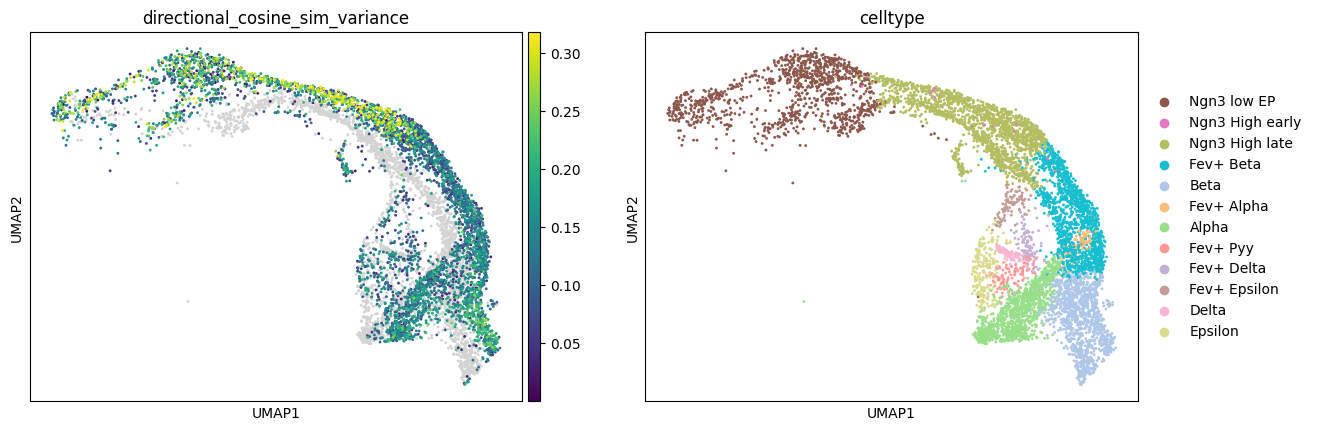

In [15]:
sc.pl.umap(adata, color=["directional_cosine_sim_variance", "celltype"], vmax="p99", )

In [16]:
cell_types = ["Ngn3 low EP", "Ngn3 High early", "Ngn3 High late", "Fev+ Alpha", "Fev+ Beta", "Fev+ Delta", "Fev+ Epsilon", "Fev+ Pyy", "Alpha", "Beta", "Delta", "Epsilon"]
adata.obs["cell_type_ordered"] = pd.Categorical(adata.obs.celltype, categories=cell_types, ordered=True)

Text(0.5, 0, 'Cell type')

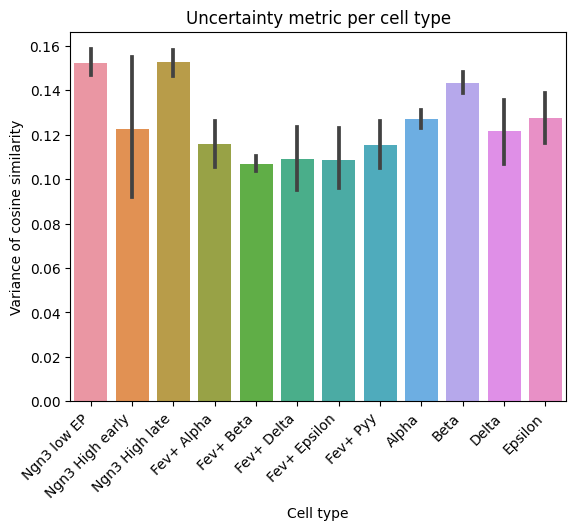

In [17]:
import seaborn as sns
g = sns.barplot(adata.obs, x="cell_type_ordered", y="directional_cosine_sim_variance")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title("Uncertainty metric per cell type")
g.set_ylabel("Variance of cosine similarity")
g.set_xlabel("Cell type")

In [18]:
adata.obs["celltype"].value_counts()

celltype
Ngn3 High late     1693
Fev+ Beta          1338
Beta               1177
Alpha              1119
Ngn3 low EP        1104
Epsilon             223
Fev+ Pyy            116
Fev+ Alpha          109
Delta               102
Fev+ Delta           99
Fev+ Epsilon         96
Ngn3 High early      21
Name: count, dtype: int64

Text(0.5, 0, 'Cell type')

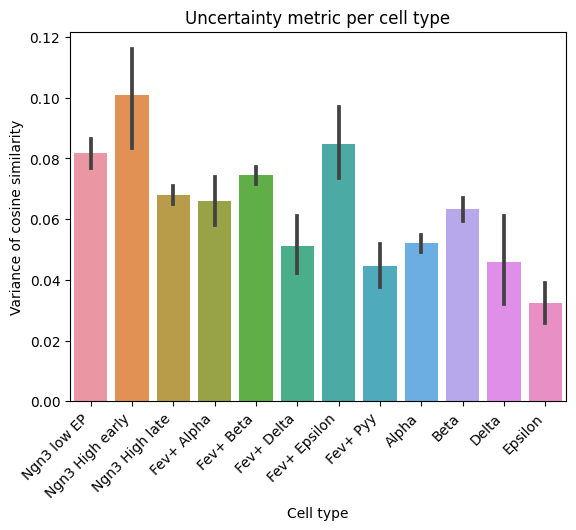

In [33]:
import seaborn as sns
g = sns.barplot(adata.obs, x="cell_type_ordered", y="directional_cosine_sim_variance")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title("Uncertainty metric per cell type")
g.set_ylabel("Variance of cosine similarity")
g.set_xlabel("Cell type")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


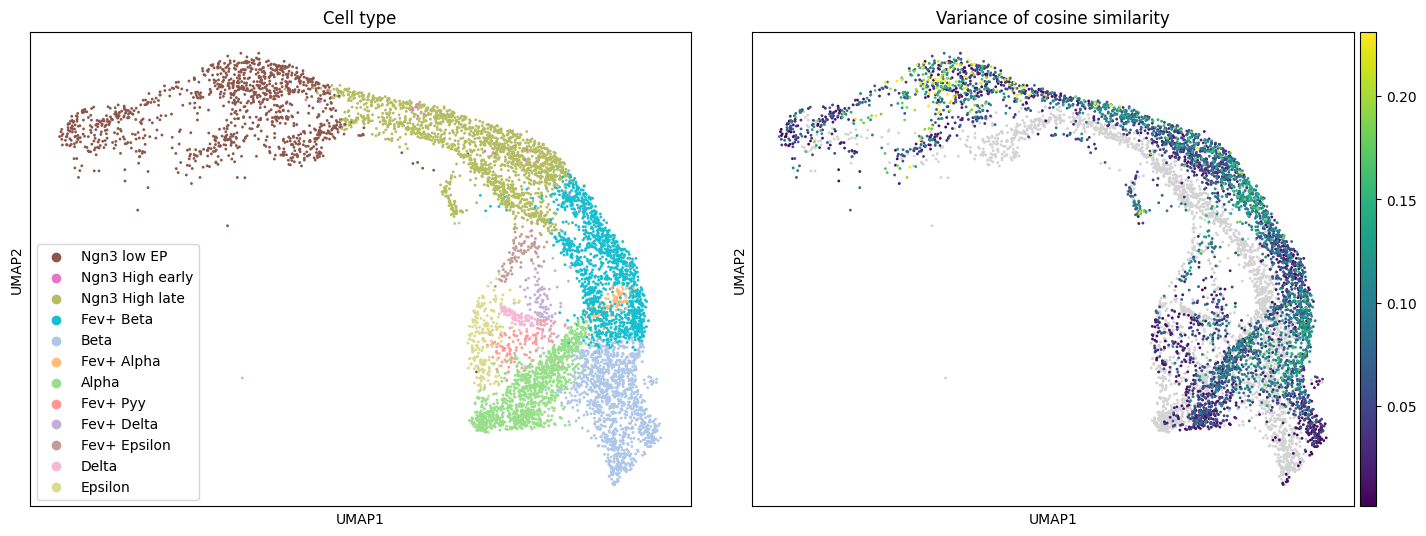

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["celltype"], vmax="p99", show=False, ax=ax1)
sc.pl.umap(adata, color=["directional_cosine_sim_variance"], vmax="p99", show=False, ax=ax2)
ax1.legend()
ax1.set_title("Cell type")
ax2.set_title("Variance of cosine similarity")
plt.tight_layout(pad=3.0)
plt.show()

In [39]:
adata.write("pancreas_downstream_results_graph_cost.h5ad")